In [255]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import math 
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_4'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'

measures = ['Puta', 'Caud', 'Thal',#'CLN_Ferritin'
            'GPi' , 'GPe', 'SN','STN', 'RN', # 'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_EXE','STR_LIM','STR_MOT','STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',

           ]

drop_c = [ 'WSKT','SC1T', 'LMIT', 'LL5T', 'SS1X']  # WSKT, SC1T are Age=20-25, Gender=F.
drop_p = [ 'LA9P','BATP','TT3P','LA9P','RA9P' ]
#drop_c = [] 
#drop_p = []

In [256]:
def get_all_dfs(img, population, study_id):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    ACC = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('ACC', population, study_id)),index_col = 0)
    ACC.columns = ['ACC_' + str(col) for col in ACC.columns]
    THA = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('THA', population, study_id)),index_col = 0)
    THA.columns = ['THA_' + str(col) for col in THA.columns]
    STR = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%('STR', population, study_id)),index_col = 0)
    STR.columns = ['STR_' + str(col) for col in STR.columns]
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_%s.csv'%(population,study_id)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]
    df = pd.concat([QSM, ACC, THA, STR, CLN], axis=1, join_axes=[QSM.index])
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0) 

# Look at age and gender of QC dataframs

In [257]:
def get_gender_len(df):    
    males   = [subject for subject in df.index if df.loc[subject]['Gender'] == 0]
    females = [subject for subject in df.index if df.loc[subject]['Gender'] == 1]
    return len(males), len(females)

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def get_gender_age_stats(df1, df2):
    
    gender = pd.DataFrame(index =['Controls', 'Patients'], columns = ['Male', 'Female'])

    gender.ix['Controls']['Male']   = get_gender_len(df1)[0]
    gender.ix['Controls']['Female'] = get_gender_len(df1)[1]
    gender.ix['Patients']['Male']   = get_gender_len(df2)[0]
    gender.ix['Patients']['Female'] = get_gender_len(df2)[1]

    print '--------------- Gender ---------------'
    print gender
    print ''
    print 'FISCHER EXACT TEST:', 'Odds Ratio=',np.round(fisher_exact(gender)[0],2), 'P-Value=',np.round(fisher_exact(gender)[1],2)
    print ''
    print '--------------- Age ---------------'
    print 'Controls Age = ', np.round(np.mean(controls_a.Age),2), '±', np.round(np.std(controls_a.Age),2)
    print 'Patients Age = ', np.round(np.mean(patients_a.Age),2), '±', np.round(np.std(patients_a.Age),2)
    print 'T-TEST =', ttest_ind(controls_a.Age.dropna(), patients_a.Age.dropna()) 
    
get_gender_age_stats(controls_a, patients_a)

--------------- Gender ---------------
         Male Female
Controls   16      5
Patients   18      3

FISCHER EXACT TEST: Odds Ratio= 0.53 P-Value= 0.7

--------------- Age ---------------
Controls Age =  39.43 ± 11.5
Patients Age =  38.67 ± 11.49
T-TEST = (0.20955983814298643, 0.83507491374011)


# Look at Ferritin

In [258]:
#def return_cln_df(population, study_id):
#    df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_%s.csv'%(population,study_id)), index_col=0)
#    return df   
#Ferr_C = reject_outliers(return_cln_df('controls', 'a')['Ferritin'].dropna())
#Ferr_P = reject_outliers(return_cln_df('patients', 'a')['Ferritin'].dropna())

Ferr_C = reject_outliers(get_all_dfs('QSM', 'controls', 'a')['CLN_Ferritin'], 3).dropna()
Ferr_P = reject_outliers(get_all_dfs('QSM', 'patients', 'a')['CLN_Ferritin'], 3).dropna()


print 'N=',len(Ferr_C), 'Controls Ferritin = ', np.round(np.median(Ferr_C),2), '±', np.round(np.std(Ferr_C),2)
print 'N=',len(Ferr_P), 'Patients Ferritin = ', np.round(np.median(Ferr_P),2), '±', np.round(np.std(Ferr_P),2)
print ''
print 'Kolmogrov-Smirnov test of Gaussian Distribution'
print 'Controls t/p=',kstest(preprocessing.scale(Ferr_C), 'norm')
print 'Patients t/p=:',kstest(preprocessing.scale(Ferr_P), 'norm')
print 'KS2Sample t/p=', ks_2samp(preprocessing.scale(Ferr_C), preprocessing.scale(Ferr_P))
print ''
#print 'Levenes test of equal variance =',levene(Ferr_C, Ferr_P, center='median')
print ''
print 'T-Test =', ttest_ind(Ferr_C, Ferr_P)


N= 18 Controls Ferritin =  147.75 ± 151.26
N= 20 Patients Ferritin =  81.25 ± 81.98

Kolmogrov-Smirnov test of Gaussian Distribution
Controls t/p= (0.17492958886477183, 0.59506906877599142)
Patients t/p=: (0.19491107285930009, 0.38556755757420125)
KS2Sample t/p= (0.17777777777777778, 0.89570149790879205)


T-Test = (2.2977545322807011, 0.027494562944686732)


# QSM Statistical modeling

In [259]:
# Compare the groups by modeling GROUP, AGE, GENDER, EFC and FD in a multiple linear regression model as in (Schmaal, Mol Psych, 2015)
# need to ensure normality of data and  homogeneity of Variance
# Normality is assessed via the Kolmogrov-Smirnov Test for each sample independently.
   # #####http://stats.stackexchange.com/questions/57885/how-to-interpret-p-value-of-kolmogorov-smirnov-test-python
# Homogeneity of Variance is assessed via Levenes Test
# Effect size is calculated with Cohen’s d-metric.

In [260]:
def cohen_d(df1,df2, metabolite):
        # Cohens D 
        from numpy import mean, std # version >= 1.7.1 && <= 1.9.1
        from math import sqrt
        import sys
        x = df1[metabolite].dropna(axis=0)
        y = df2[metabolite].dropna(axis=0)
        return (mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0)



def make_statistical_comparison(df_controls, df_patients, stat, measures = measures):
    df_controls['Population'] = 1
    df_patients['Population'] = 0
    
    cols = ['N','Controls', 'Patients','Levene','KS', 'KS_C', 'KS_P','D', 'Statistic', 'p_val', 'p_fdr', 'sig']
    dfs = pd.DataFrame(index= cols, columns=measures)

    for measure in measures:
        df = pd.concat([controls_a, patients_a])
        
        if stat == 'MR':
            formula = '%s ~ Population + Age + Gender + EFC_PHS + FD'%measure
            model   = smf.ols(formula=formula, data = df)
            fit     = model.fit()
            p_val   = np.round(fit.pvalues[1],5)
            t_val   = np.round(fit.tvalues[1],3)
        
        elif stat == 'MW':
            
            t_val, p_val = mannwhitneyu(df_controls[measure].dropna(), df_patients[measure].dropna())
            
        elif stat == 'TT':
            t_val, p_val = ttest_ind(df_controls[measure].dropna(), df_patients[measure].dropna())
        
        xval = 1000
        npr  = 4
        dfs.ix['N'][measure] = len(df_controls.index), len(df_patients.index)
        dfs.ix['Levene'][measure] = np.round(levene(df_controls[measure], df_patients[measure])[1],2)
        dfs.ix['KS'][measure] = np.round(ks_2samp(preprocessing.scale(df_controls[measure]), 
                                         preprocessing.scale(df_patients[measure]))[1], 2)
        dfs.ix['KS_C'][measure] = np.round(kstest(preprocessing.scale(df_controls[measure]), 'norm')[0],2)
        dfs.ix['KS_P'][measure] = np.round(kstest(preprocessing.scale(df_patients[measure]), 'norm')[0],2)
        dfs.ix['D'][measure]    = cohen_d(controls_a, patients_a,measure)
        dfs.ix['Controls'][measure] = '%s±%s'%(xval*np.round(np.mean(df_controls[measure]),npr), 
                                              xval*np.round(np.std(df_controls[measure]), npr))   
        dfs.ix['Patients'][measure] = '%s±%s'%(xval*np.round(np.mean(df_patients[measure]),npr), 
                                              xval*np.round(np.std(df_patients[measure]), npr))   
        dfs.ix['D'][measure]    = np.round(cohen_d(controls_a, patients_a,measure),2)
        dfs.ix['Statistic'][measure]= np.round(t_val,2)        
        dfs.ix['p_val'][measure]    = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
    
    dfs = dfs.T.sort('p_val')
    dfs['p_fdr'] = fdrcorrection0(dfs.p_val)[1]
    dfs['sig'] = fdrcorrection0(dfs.p_val)[0]
    return dfs, df 


In [261]:
X, XX = make_statistical_comparison(controls_a, patients_a, 'MR')
X

Puta p = 0.006
Caud p = 0.018
GPi p = 0.048
STN p = 0.005


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
STN,"(21, 22)",75.8±21.2,39.3±32.3,0.15,0.92,0.09,0.11,1.3,2.96,0.0054,0.02232,True
Puta,"(21, 22)",0.1±16.7,-8.8±14.9,0.64,0.88,0.15,0.11,0.55,2.95,0.00558,0.02232,True
Caud,"(21, 22)",18.0±11.8,11.4±9.9,0.7,0.4,0.16,0.15,0.6,2.48,0.01782,0.04752,True
GPi,"(21, 22)",100.9±25.2,91.6±25.2,0.65,0.65,0.16,0.13,0.36,2.05,0.04763,0.09526,False
RN,"(21, 22)",124.7±45.4,104.1±37.5,0.48,1,0.11,0.11,0.48,1.72,0.09408,0.1368533,False
SN,"(21, 22)",121.5±19.8,104.4±30.4,0.04,0.92,0.16,0.16,0.65,1.68,0.10264,0.1368533,False
Thal,"(21, 22)",-39.0±11.7,-36.6±14.2,0.24,0.99,0.08,0.11,-0.18,1.48,0.1469,0.1678857,False
GPe,"(21, 22)",101.4±17.6,95.4±21.1,0.17,0.89,0.14,0.13,0.3,1.33,0.19258,0.19258,False


In [262]:
X, XX = make_statistical_comparison(controls_a, patients_a, 'MR', measures=['BrainStem','BasalGanglia'])
X

BrainStem p = 0.01
BasalGanglia p = 0.002


,N,Controls,Patients,Levene,KS,KS_C,KS_P,D,Statistic,p_val,p_fdr,sig
BasalGanglia,"(21, 22)",19.4±10.0,12.7±11.4,0.13,0.39,0.17,0.18,0.6,3.35,0.0019,0.0038,True
BrainStem,"(21, 22)",107.3±22.8,82.6±25.7,0.48,0.66,0.19,0.13,1,2.73,0.0097,0.0097,True


In [263]:
u = mean(patients_a.STN) + 2 * std(patients_a.STN) 
l = mean(patients_a.STN) - 2 * std(patients_a.STN)
print u * 1000
print l * 1000
print patients_a.STN * 1000

103.842801992
-25.1925292645
BE9P     23.4510
HJEP     51.0370
BATP     39.6895
LA9P     -4.1700
LT5P     68.3390
SM6U     34.5140
RL7P     56.4140
SGKP     22.1230
HHQP     45.6870
SA5U     58.1185
THCP     55.8410
PC5P     22.0160
SBQP     90.4605
NT6P     42.0145
TT3P     83.8205
CB4P     -3.3270
YU1P     -0.3955
RA9P    -37.8220
SULP     40.2230
KDDP     55.2320
DF2P    100.0255
AA8P     21.8615
Name: STN, dtype: float64


In [264]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

reject_outliers(patients_a.STN)

BE9P    0.023451
HJEP    0.051037
BATP    0.039690
LA9P   -0.004170
LT5P    0.068339
SM6U    0.034514
RL7P    0.056414
SGKP    0.022123
HHQP    0.045687
SA5U    0.058118
THCP    0.055841
PC5P    0.022016
SBQP    0.090461
NT6P    0.042015
TT3P    0.083821
CB4P   -0.003327
YU1P   -0.000396
RA9P   -0.037822
SULP    0.040223
KDDP    0.055232
DF2P    0.100026
AA8P    0.021862
Name: STN, dtype: float64

In [265]:
for measure in ['SN']:
    formula = '%s ~ Age' %measure
    p_model   = smf.ols(formula=formula, data = patients_a).fit()
    c_model   = smf.ols(formula=formula, data = controls_a).fit()
    t,p = mannwhitneyu(c_model.resid, p_model.resid)
    print measure,p  

SN 0.420253142906


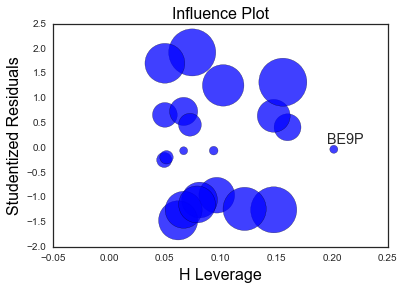

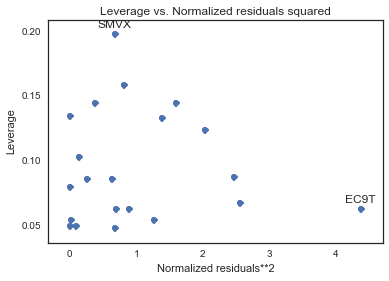

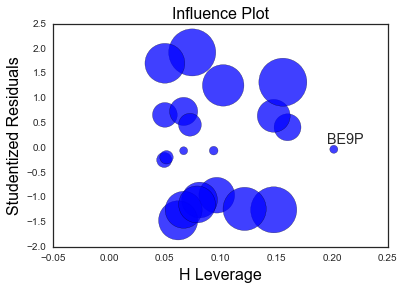

In [266]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(c_model)
influence_plot(p_model)

In [267]:
patients_a.sort('STN').STN

RA9P   -0.037822
LA9P   -0.004170
CB4P   -0.003327
YU1P   -0.000396
AA8P    0.021862
PC5P    0.022016
SGKP    0.022123
BE9P    0.023451
SM6U    0.034514
BATP    0.039690
SULP    0.040223
NT6P    0.042015
HHQP    0.045687
HJEP    0.051037
KDDP    0.055232
THCP    0.055841
RL7P    0.056414
SA5U    0.058118
LT5P    0.068339
TT3P    0.083821
SBQP    0.090461
DF2P    0.100026
Name: STN, dtype: float64

In [268]:
measures = ['Puta', 'Caud','GPi' , 'GPe', 'SN','STN', 'RN', 'Thal']

In [269]:
def plot_heat(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = 'jet'
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr,cmap=cmap, vmin = -1, vmax=1, mask=mask, square=True, 
                linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})
    
def plot_corrmat(df):
    df_list = [df[measure] for measure in measures]
    df = pd.concat(df_list,  axis=1)
    corr = df.corr('pearson')
    plot_heat(corr)
    return corr

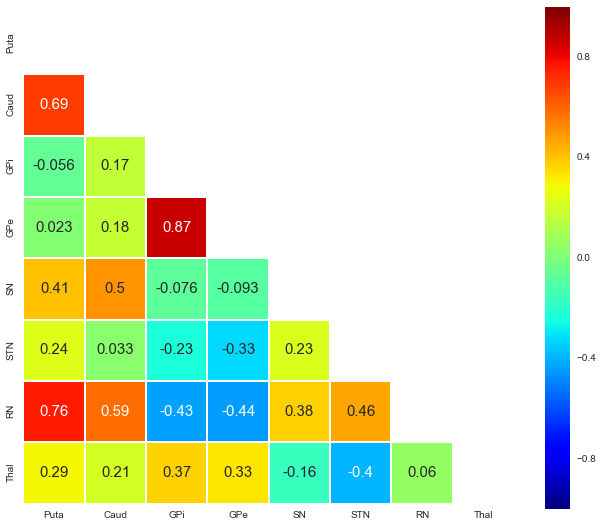

In [270]:
corr_c  = plot_corrmat(controls_a)

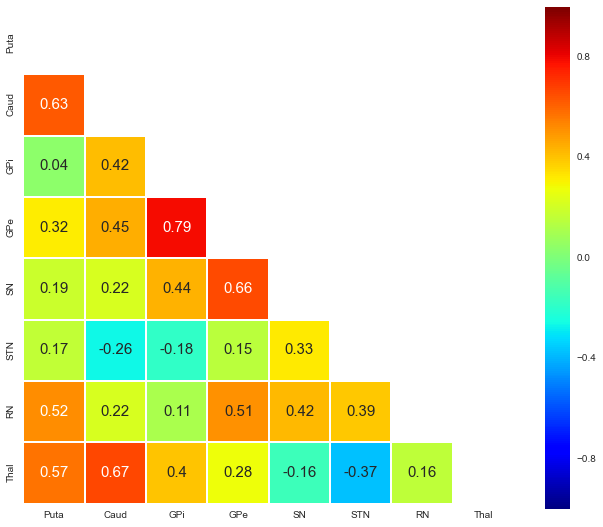

In [271]:
corr_p = plot_corrmat(patients_a)

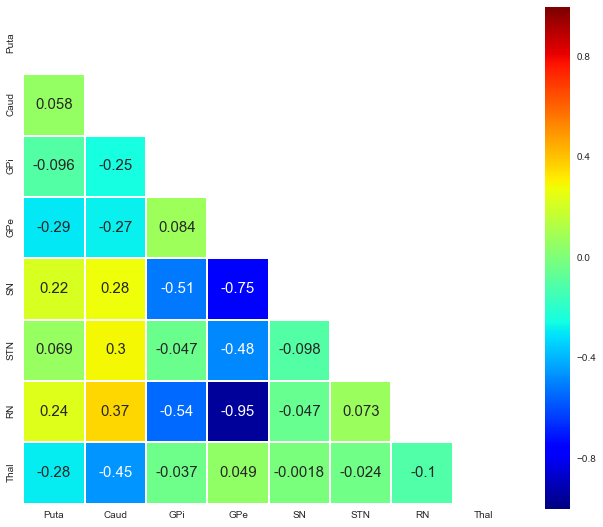

In [272]:
diff = corr_c - corr_p
plot_heat(diff)

In [273]:
diff[diff > -0.2] = np.nan

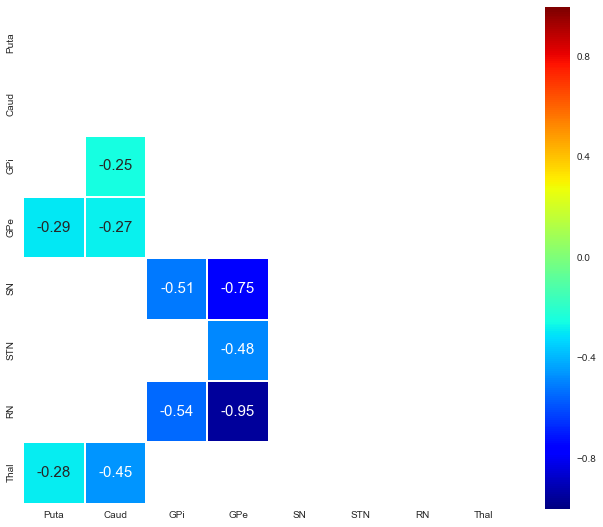

In [274]:
plot_heat(diff)

In [275]:
fit = smf.ols(formula='SN ~ Population + Age + Gender + FD', data=XX).fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:                     SN   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.462
Date:                Wed, 05 Oct 2016   Prob (F-statistic):              0.233
Time:                        12:24:00   Log-Likelihood:                 96.621
No. Observations:                  42   AIC:                            -183.2
Df Residuals:                      37   BIC:                            -174.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0865      0.015      5.732      0.0

In [276]:
patients_a.sort('FD').FD

RL7P    0.074231
HJEP    0.093902
SULP    0.125723
YU1P    0.131411
BATP    0.136510
TT3P    0.145866
LA9P    0.147449
PC5P    0.148735
BE9P    0.149829
NT6P    0.155556
SM6U    0.165781
LT5P    0.169576
SBQP    0.200882
SGKP    0.222883
DF2P    0.238154
THCP    0.320480
SA5U    0.326513
KDDP    0.399443
HHQP    0.401591
RA9P    0.514138
CB4P    0.857230
AA8P         NaN
Name: FD, dtype: float64

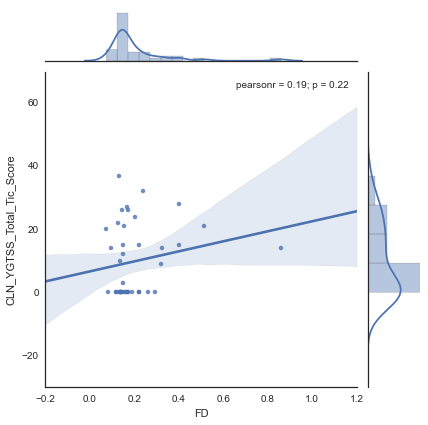

In [277]:
sns.jointplot(x=XX.FD, y=XX.CLN_YGTSS_Total_Tic_Score, kind = 'reg')

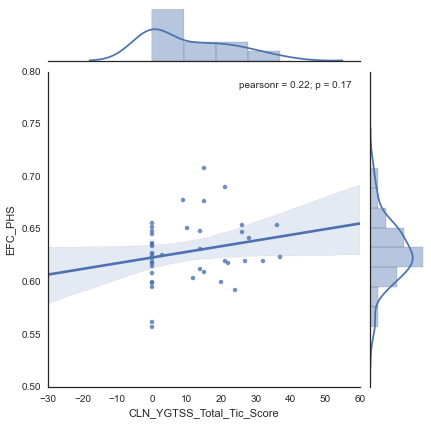

In [278]:
sns.jointplot(x=XX.CLN_YGTSS_Total_Tic_Score, y=XX.EFC_PHS, kind = 'reg')

In [280]:
higher_better = ['SNR_PHS','CNR_PHS', 'FBER_PHS',]
lower_better  = ['EFC_PHS', 'FWHM_PHS', 'QI1_PHS', 'FD']  

In [358]:
def get_lower_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) - 3*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v < cut:
            print s,v
    print ''

In [359]:
get_lower_outlier(XX, 'SNR_PHS')
get_lower_outlier(XX, 'CNR_PHS')
get_lower_outlier(XX, 'FBER_PHS')

SNR_PHS
mean= 2.62868695535 cut= 1.47438298746

CNR_PHS
mean= 0.0541635745698 cut= -0.0781148606378

FBER_PHS
mean= 6.66446456152 cut= 0.444252108758



In [361]:
def get_higher_outlier(df, measure):
    print measure
    df = df[measure]
    cut =  np.mean(df) + 2*np.std(df)
    print 'mean=',np.mean(df), 'cut=',cut
    for s,v in zip(df.index,df):    
        if v > cut:
            print s,v

In [362]:
get_higher_outlier(XX, 'EFC_PHS')
get_higher_outlier(XX, 'FWHM_PHS')
get_higher_outlier(XX, 'QI1_PHS')
get_higher_outlier(XX, 'FD')

EFC_PHS
mean= 0.627994278216 cut= 0.687122601092
LA9P 0.7080005941
RA9P 0.6901593489
FWHM_PHS
mean= 3.66515697674 cut= 4.30711420915
BATP 4.51808
TT3P 4.32115
QI1_PHS
mean= 0.133349079149 cut= 0.193605277589
LA9P 0.2072303572
RA9P 0.2266500554
FD
mean= 0.203152371988 cut= 0.475854259868
CB4P 0.8572296358
RA9P 0.5141378981
